In [76]:
import pandas as pd

In [77]:
import matplotlib.pyplot as plt

In [78]:
data = pd.read_csv("articles.B2M.csv")
data = pd.read_csv("authors.B2M.csv")
data = pd.read_csv("paper_counts.csv")

In [79]:
authors = pd.read_csv("authors.B2M.csv")
display(authors.head())

,PMID,AuthorN,AuthorForename,AuthorLastname,AuthorInitials,AuthorAffiliation
0,10575721,1,E,Nerkowski,E,"Equipe B2M, ENSAM, Aix-en-Provence."
1,10575721,2,P,Calas,P,NaN
2,10575721,3,A,Mouttet,A,NaN
3,10617805,1,M,Esslimani,M,"Service d'Anatomie Pathologique, Hôpital Gui d..."
4,10617805,2,I,Serre,I,NaN


In [80]:
authors["AuthorName"] = authors["AuthorLastname"] + ", " + authors["AuthorInitials"]

In [81]:
author_counts = (
    authors.groupby("AuthorName")["PMID"]
    .nunique()
    .reset_index()
)
author_counts.columns = ["AuthorName", "PaperCount"]
author_counts = author_counts.sort_values(
    by="PaperCount",
    ascending=False
)
top_authors = author_counts.head(10)
top_authors

,AuthorName,PaperCount
4319,"Wang, Y",17
4314,"Wang, X",14
2377,"Li, Y",13
4294,"Wang, J",11
4666,"Zhang, H",11
4683,"Zhang, Y",11
4303,"Wang, Q",9
4321,"Wang, Z",9
2460,"Liu, Y",9
2458,"Liu, X",9


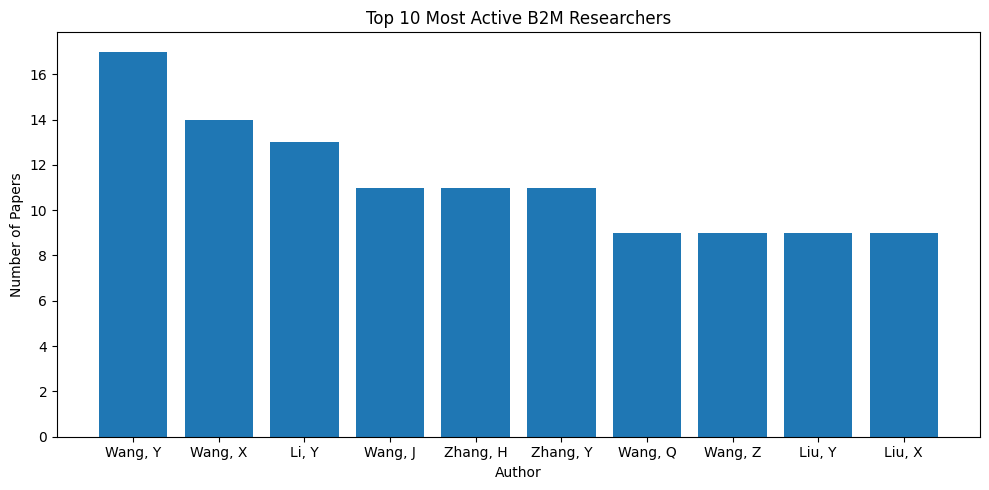

In [82]:
top_authors = author_counts.head(10)
plt.figure(figsize=(10, 5))
plt.bar(
    top_authors["AuthorName"],
    top_authors["PaperCount"]
)

plt.xlabel("Author")
plt.ylabel("Number of Papers")
plt.title("Top 10 Most Active B2M Researchers")
plt.tight_layout()
plt.show()

In [83]:
author_affiliation = (
    authors[["AuthorName", "AuthorAffiliation"]]
    .dropna(subset=["AuthorAffiliation"])
    .groupby("AuthorName")
    .first()
    .reset_index()
)
author_counts_with_affil = author_counts.merge(
    author_affiliation,
    on="AuthorName",
    how="left"
)
author_counts_with_affil.head(10)

,AuthorName,PaperCount,AuthorAffiliation
0,"Wang, Y",17,"Department of Biobank, Renji Hospital, School ..."
1,"Wang, X",14,Shanghai Institute of Endocrine and Metabolic ...
2,"Li, Y",13,"Department of Immunology, Norman Bethune Colle..."
3,"Wang, J",11,Qingdao Institute of Animal Science and Veteri...
4,"Zhang, H",11,"Institute of Medical Science, University of To..."
5,"Zhang, Y",11,"College of Animal Science and Technology, Sich..."
6,"Wang, Q",9,"Department of Forensic Medicine, Southern Medi..."
7,"Wang, Z",9,"Department of Obstetrics and Gynecology, Union..."
8,"Liu, Y",9,Shanghai Institute of Endocrine and Metabolic ...
9,"Liu, X",9,"William B. Schwartz Division of Nephrology, Tu..."


In [84]:
top_authors = author_counts.head(10)
top_author_names = top_authors["AuthorName"].tolist()
authors_top = authors[authors["AuthorName"].isin(top_author_names)]
authors_top

,PMID,AuthorN,AuthorForename,AuthorLastname,AuthorInitials,AuthorAffiliation,AuthorName
112,12464555,1,H,Zhang,H,"Institute of Medical Science, University of To...","Zhang, H"
492,18692183,6,Zaijuan,Wang,Z,NaN,"Wang, Z"
541,19012427,2,Yan,Zhang,Y,NaN,"Zhang, Y"
661,20036209,2,Junping,Wang,J,NaN,"Wang, J"
709,20599650,2,Yang,Li,Y,NaN,"Li, Y"
...,...,...,...,...,...,...,...
5643,37526345,21,Zhihua,Wang,Z,"Department of Urology, Tongji Hospital, Tongji...","Wang, Z"
5648,37550685,1,Xianming,Wang,X,"Department of Orthopedic Surgery, The Second A...","Wang, X"
5656,37550685,9,Qing,Wang,Q,"Department of Orthopedic Surgery, The Second A...","Wang, Q"
5713,37838728,1,Yan,Zhang,Y,"Department of Anesthesiology, The Second Affil...","Zhang, Y"


In [85]:
pip install networkx


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [86]:
import networkx as nx
author_counts = (
    authors.groupby("AuthorName")["PMID"]
    .nunique()
    .reset_index()
)
author_counts.columns = ["AuthorName", "PaperCount"]
author_counts = author_counts.sort_values("PaperCount", ascending=False)
N = 20
top_names = author_counts.head(N)["AuthorName"].tolist()
authors_top = authors[authors["AuthorName"].isin(top_names)][["PMID", "AuthorName"]]
pairs = authors_top.merge(authors_top, on="PMID")
pairs = pairs[pairs["AuthorName_x"] != pairs["AuthorName_y"]]
collab = (
    pairs.groupby(["AuthorName_x", "AuthorName_y"])["PMID"]
    .nunique()
    .reset_index()
)
collab.columns = ["Author1", "Author2", "SharedPapers"]


Text(0.5, 1.0, 'Author Collaboration Network (Top Active Researchers)')

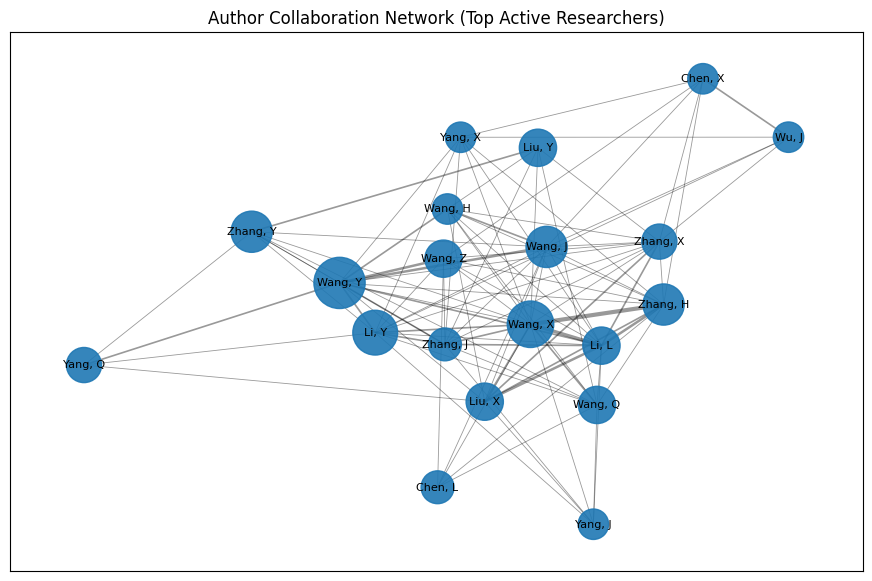

In [87]:
collab["PairKey"] = collab.apply(lambda r: tuple(sorted([r["Author1"], r["Author2"]])), axis=1)
collab = collab.groupby("PairKey")["SharedPapers"].max().reset_index()
collab[["Author1", "Author2"]] = pd.DataFrame(collab["PairKey"].tolist(), index=collab.index)
collab = collab.drop(columns=["PairKey"])
G = nx.Graph()
paper_count_dict = dict(zip(author_counts["AuthorName"], author_counts["PaperCount"]))
for name in top_names:
    G.add_node(name, papers=paper_count_dict.get(name, 1))
edge_list = collab[["Author1", "Author2", "SharedPapers"]].values.tolist()
G.add_weighted_edges_from(edge_list) 
pos = nx.spring_layout(G, seed=42)
node_sizes = [G.nodes[n]["papers"] * 80 for n in G.nodes()] 
edge_widths = [G[u][v]["weight"] * 0.6 for u, v in G.edges()]
plt.figure(figsize=(11, 7))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Author Collaboration Network (Top Active Researchers)")

In [88]:
authors["AuthorName"] = (
    authors["AuthorLastname"].fillna("") + ", " +
    authors["AuthorInitials"].fillna("")
)
articles = pd.read_csv("articles.B2M.csv")
authors["AuthorName"] = (
    authors["AuthorLastname"].fillna("") + ", " +
    authors["AuthorInitials"].fillna("")
)
authors["AuthorName"] = authors["AuthorName"].str.strip()

authors_year = authors.merge(
    articles[["PMID", "Year"]],
    on="PMID",
    how="left"
)
first_year = (
    authors_year
    .groupby("AuthorName")["Year"]
    .min()
    .reset_index()
)
first_year.columns = ["AuthorName", "FirstYear"]
new_authors_per_year = (
    first_year
    .groupby("FirstYear")["AuthorName"]
    .count()
    .reset_index()
)
new_authors_per_year.columns = ["Year", "NewAuthors"]


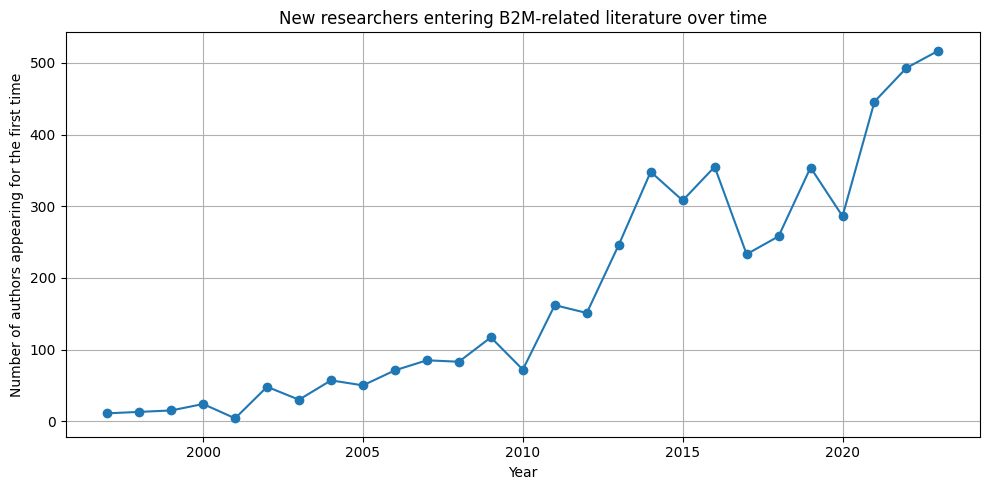

In [89]:
new_authors_per_year = new_authors_per_year.sort_values("Year")
plt.figure(figsize=(10, 5))

plt.plot(
    new_authors_per_year["Year"],
    new_authors_per_year["NewAuthors"],
    marker="o"
)

plt.xlabel("Year")
plt.ylabel("Number of authors appearing for the first time")
plt.title("New researchers entering B2M-related literature over time")

plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
articles["Text"] = (
    articles["Title"].fillna("") + " " +
    articles["Abstract"].fillna("")
).str.lower()
categories = {
    "Hematologic malignancies": ["leukemia", "lymphoma", "myeloma"],
    "Immunology / antigen presentation": ["immune", "antigen", "mhc", "t cell"],
    "Infection / inflammation": ["infection", "inflammatory", "virus", "bacterial"],
    "Renal / kidney disease": ["kidney", "renal", "nephro"],
    "Solid tumors & oncology": ["cancer", "tumor", "oncology", "carcinoma"]
}
def assign_category(text):
    for category, keywords in categories.items():
        for kw in keywords:
            if kw in text:
                return category
    return "Unclassified/Other"
articles["Category"] = articles["Text"].apply(assign_category)
category_year_counts = (
    articles
    .groupby(["Year", "Category"])
    .size()
    .reset_index(name="Count")
)
category_pivot = category_year_counts.pivot(
    index="Year",
    columns="Category",
    values="Count"
).fillna(0)


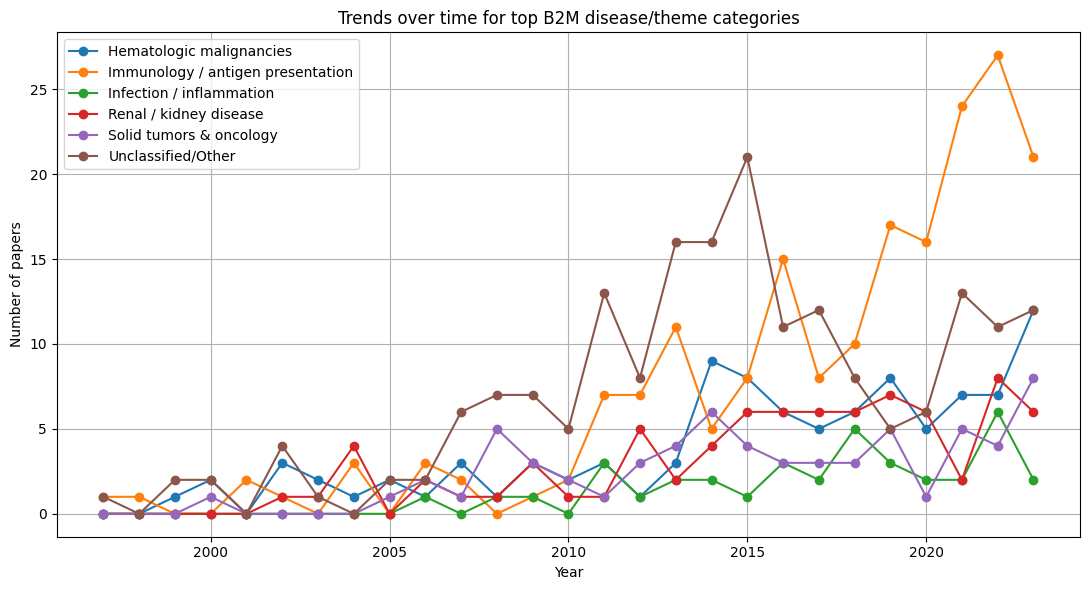

In [92]:
plt.figure(figsize=(11, 6))

for category in category_pivot.columns:
    plt.plot(
        category_pivot.index,
        category_pivot[category],
        marker="o",
        label=category
    )

plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.title("Trends over time for top B2M disease/theme categories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

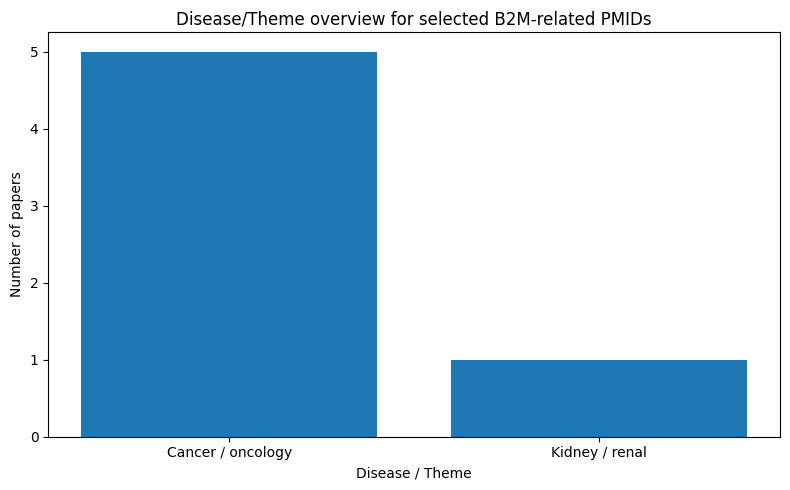

In [105]:
pmids = [29979645, 31423206, 33658560, 35368100, 35841593, 36055572]
df = articles[articles["PMID"].isin(pmids)].copy()
df["Text"] = (
    df["Title"].fillna("") + " " +
    df["Abstract"].fillna("")
).str.lower()
categories = {
    "Kidney / renal": ["kidney", "renal", "nephro", "urinary"],
    "Cancer / oncology": ["cancer", "tumor", "tumour", "oncology", "lymphoma", "leukemia"],
    "Immunology": ["immune", "immun", "mhc", "antigen", "inflammation"],
    "Infection": ["infection", "virus", "viral", "covid"]
} 
df["DiseaseTheme"] = df["Text"].apply(assign_category)
theme_counts = df["DiseaseTheme"].value_counts().reset_index()
theme_counts.columns = ["DiseaseTheme", "PaperCount"]
plt.figure(figsize=(8, 5))
plt.bar(theme_counts["DiseaseTheme"], theme_counts["PaperCount"])
plt.xlabel("Disease / Theme")
plt.ylabel("Number of papers")
plt.title("Disease/Theme overview for selected B2M-related PMIDs")
plt.tight_layout()
plt.show()
    